## **Task: Sentiment Analysis**

The car reviews dataset is obtained from [here](https://www.kaggle.com/code/amitranjan01/edmunds-data-analysis-car-rating-analysis/data). This dataset contains the reviews of cars with its ratings. The ratings are between 1 to 5. As the data is imbalanced, categorised the data with rating less than equal to 3 as negative review and the data with rating greater than 3 as positive review. Thus formulated the task as binary classification problem.

Further handled the class imbalance problem using WeightedRandomSampler. Used BERT pretrained embeddings and BERTSeBertForSequenceClassification model for training.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
%cd gdrive/MyDrive/Colab Notebooks/carrev

**Data Analysis and Preprocessing**

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
##Loading data
df=pd.read_csv("data/Scraped_Car_Review.csv")

As review title also contains sentiment knowledge, contatenating Review title to reviews

In [ ]:
df['review']=df['review_title']+df['review']

In [ ]:
label_counts=df.rating.value_counts()
print(label_counts)

5    4224
4    2711
3     840
2     586
1     138
Name: rating, dtype: int64


Only a few samples are available for lower ratings. So the ratings greater than 3 are considered as positive and ratings less than equal o 3 are consdered as negative reviews

In [ ]:
df['rating']=np.where(df["rating"] >3, 'positive', 'negative')
label_counts=df.rating.value_counts()
print(label_counts)

positive    6935
negative    1564
Name: rating, dtype: int64


Creating label dict for training purpose

In [ ]:
possible_labels=df.rating.unique()
label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
df.rating = df['rating'].map(label_dict)
print(label_dict)

{'positive': 0, 'negative': 1}


In [ ]:
label_counts=df.rating.value_counts()
print(label_counts)

0    6935
1    1564
Name: rating, dtype: int64


Data is affected by class imbalance

**Train data, Validation data and Test data Preparation**

In [ ]:
from sklearn.model_selection import train_test_split
X_train_, X_test, y_train_, y_test = train_test_split(df.index.values, df.rating.values,  test_size=0.10,  random_state=2, stratify=df.rating.values)
X_train, X_val, y_train, y_val = train_test_split(X_train_, y_train_,  test_size=0.20,  random_state=2, stratify=y_train_)

In [ ]:
df['data_type'] = ['not_set']*df.shape[0]
df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'
df.loc[X_test, 'data_type'] = 'test'
df.groupby(['rating', 'data_type']).count()

Unnamed: 0    id  review_date  author_name  vehicle_title  \
rating data_type                                                              
0      test              694   694          694          694            694   
       train            4993  4993         4993         4993           4993   
       val              1248  1248         1248         1248           1248   
1      test              156   156          156          156            156   
       train            1126  1126         1126         1126           1126   
       val               282   282          282          282            282   

                  review_title  review  
rating data_type                        
0      test                694     694  
       train              4993    4993  
       val                1248    1248  
1      test                156     156  
       train              1126    1126  
       val                 282     282

**Installing the Hugging Face Library**

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 8.4 MB/s 
     |████████████████████████████████| 6.6 MB 40.1 MB/s 
     |████████████████████████████████| 596 kB 52.9 MB/s 
     |████████████████████████████████| 101 kB 9.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from transformers import BertTokenizer
from transformers import BertForSequenceClassification
from transformers import AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler,WeightedRandomSampler
from torch.utils.data import TensorDataset

import torch
from tqdm.notebook import tqdm
import numpy as np
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix


**BERT Tokenizer**

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',do_lower_case=True)

**Input Formatting**

Added special tokens to the start and end of each test.

Padded & truncateed all text to a single constant length.

Explicitly differentiated real tokens from padding tokens with the attention mask.

In [ ]:
encoded_data_train = tokenizer.batch_encode_plus(
    df[df.data_type=='train'].review.values,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    # truncation=True,
    max_length=256,
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    df[df.data_type=='val'].review.values,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    # truncation=True,
    max_length=256,
    return_tensors='pt'
)

encoded_data_test = tokenizer.batch_encode_plus(
    df[df.data_type=='test'].review.values,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    # truncation=True,
    max_length=256,
    return_tensors='pt'
)

input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df[df.data_type=='train'].rating.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df[df.data_type=='val'].rating.values)

input_ids_test = encoded_data_test['input_ids']
attention_masks_test = encoded_data_test['attention_mask']
labels_test = torch.tensor(df[df.data_type=='test'].rating.values)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2329: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)
dataset_test = TensorDataset(input_ids_test, attention_masks_test, labels_test)

Load BertForSequenceClassification, the pretrained BERT model with a single 
linear classification layer on top. 

Used dropout for handling overfitting

In [ ]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', 
                                                      num_labels = len(label_dict),
                                                      output_attentions = False,
                                                      output_hidden_states = False,
                                                      attention_probs_dropout_prob=0.5,
                                                      hidden_dropout_prob=0.5)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

**Data Loader**

Used WeightedRandomSampler to handle class imbalance

In [ ]:
batch_size = 8
label_counts=df.rating.value_counts()
class_sample_counts=[label_counts[idx] for idx in label_counts.index ]
weights = 1. / torch.tensor(class_sample_counts, dtype=torch.float)
samples_weights_train = weights[labels_train]
dataloader_train = DataLoader(
    dataset_train,
    # sampler=RandomSampler(dataset_train),
    
    sampler=WeightedRandomSampler(weights=samples_weights_train,num_samples=len(samples_weights_train),replacement=True),
    batch_size=batch_size
)
samples_weights_val= weights[labels_val]
dataloader_val = DataLoader(
    dataset_val,
    # sampler=RandomSampler(dataset_val),
    sampler=WeightedRandomSampler(weights=samples_weights_val,num_samples=len(samples_weights_val),replacement=True),
    batch_size=batch_size
)
samples_weights_test= weights[labels_test]
dataloader_test = DataLoader(
    dataset_test,
    # sampler=RandomSampler(dataset_val),
    sampler=WeightedRandomSampler(weights=samples_weights_test,num_samples=len(samples_weights_test),replacement=True),
    batch_size=batch_size
)

**Optimizer & Learning Rate Scheduler**

In [ ]:
optimizer = AdamW(model.parameters(), lr = 1e-5, eps = 1e-8)
epochs = 10
scheduler = get_linear_schedule_with_warmup(optimizer,num_warmup_steps=0,num_training_steps = len(dataloader_train)*epochs)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


**Performance Metrics**

In [ ]:
def confusion_matrix_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return confusion_matrix(labels_flat, preds_flat)

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average = 'weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    
    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy:{len(y_preds[y_preds==label])}/{len(y_true)}\n')

**Creating Training Loop**

In [ ]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(device)

cuda


In [ ]:
def evaluate(dataloader_val):
    model.eval()    
    loss_val_total = 0
    predictions, true_vals = [], []    
    for batch in tqdm(dataloader_val):        
        batch = tuple(b.to(device) for b in batch)        

        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }
        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

In [ ]:
training_stats=[]
for epoch in tqdm(range(1, epochs+1)):
    model.train()
    loss_train_total = 0
    
    progress_bar = tqdm(dataloader_train, 
                        desc='Epoch {:1d}'.format(epoch), 
                        leave=False, 
                        disable=False)
    
    for batch in progress_bar:
        model.zero_grad()
        batch = tuple(b.to(device) for b in batch)
        # print(batch[2])
        inputs = {
            'input_ids': batch[0],
            'attention_mask': batch[1],
            'labels': batch[2]
        }
        
        outputs = model(**inputs)
        loss = outputs[0]
        loss_train_total +=loss.item()
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})     
    
    #torch.save(model.state_dict(), f'Models/BERT_ft_Epoch{epoch}.model')
    
    tqdm.write('\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_val)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (weighted): {val_f1}')
    training_stats.append(
        {
            'epoch': epoch,
            'Training Loss': loss_train_avg,
            'Valid. Loss': val_loss,
            'Valid. F1 Score(weighted).': val_f1

        }
    )

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/765 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.6258645529840506


  0%|          | 0/192 [00:00<?, ?it/s]

Validation loss: 0.40931819860513013
F1 Score (weighted): 0.8487161858571353


Epoch 2:   0%|          | 0/765 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.4580073256459501


  0%|          | 0/192 [00:00<?, ?it/s]

Validation loss: 0.32535871490836143
F1 Score (weighted): 0.8683936088985457


Epoch 3:   0%|          | 0/765 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.41316805621182995


  0%|          | 0/192 [00:00<?, ?it/s]

Validation loss: 0.2864128583557128
F1 Score (weighted): 0.8868824345820333


Epoch 4:   0%|          | 0/765 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.3865645440794479


  0%|          | 0/192 [00:00<?, ?it/s]

Validation loss: 0.2606840973409514
F1 Score (weighted): 0.9097122023960578


Epoch 5:   0%|          | 0/765 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.3807532064300152


  0%|          | 0/192 [00:00<?, ?it/s]

Validation loss: 0.2932815348128012
F1 Score (weighted): 0.901836023685604


Epoch 6:   0%|          | 0/765 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.37237257723471306


  0%|          | 0/192 [00:00<?, ?it/s]

Validation loss: 0.30814202141482383
F1 Score (weighted): 0.9032679738562092


Epoch 7:   0%|          | 0/765 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.3680638310712537


  0%|          | 0/192 [00:00<?, ?it/s]

Validation loss: 0.34890810192155186
F1 Score (weighted): 0.8941277823029989


Epoch 8:   0%|          | 0/765 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.34344168511444545


  0%|          | 0/192 [00:00<?, ?it/s]

Validation loss: 0.35773962857638253
F1 Score (weighted): 0.8973761888455722


Epoch 9:   0%|          | 0/765 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.355919500492708


  0%|          | 0/192 [00:00<?, ?it/s]

Validation loss: 0.33108453120924725
F1 Score (weighted): 0.8947727252554586


Epoch 10:   0%|          | 0/765 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.3367161348218622


  0%|          | 0/192 [00:00<?, ?it/s]

Validation loss: 0.351275540740365
F1 Score (weighted): 0.8993076923076924


In [ ]:
pd.set_option('precision', 2)
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
df_stats

,Training Loss,Valid. Loss,Valid. F1 Score(weighted).
epoch,,,
1,0.63,0.41,0.85
2,0.46,0.33,0.87
3,0.41,0.29,0.89
4,0.39,0.26,0.91
5,0.38,0.29,0.90
6,0.37,0.31,0.90
7,0.37,0.35,0.89
8,0.34,0.36,0.90
9,0.36,0.33,0.89


While training, training loss is decreasing. Validation loss is also decreasing and slightly increasing after epoch=4 and then oscilating. So stopping the training at epochs=10, We could also stop at epochs =4. 

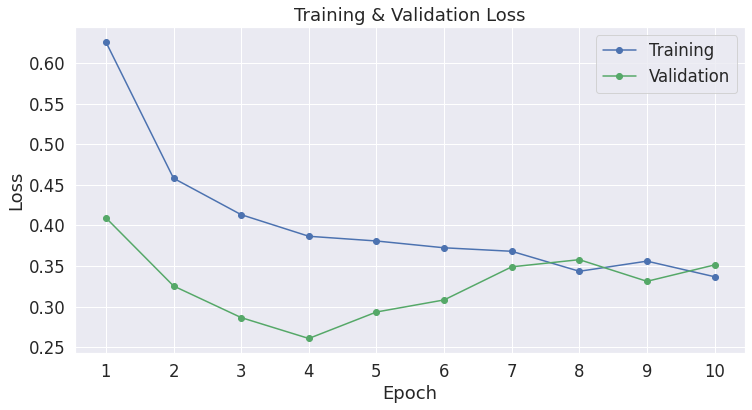

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns
sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)


plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")


plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4,5,6,7,8,9,10])

plt.show()

**Performance on Test data**

In [ ]:
test_loss, test_predictions, test_true_vals = evaluate(dataloader_test)
test_f1 = f1_score_func(test_predictions, test_true_vals)

  0%|          | 0/107 [00:00<?, ?it/s]

In [ ]:
print(test_f1)

0.8943054972600288


In [ ]:
confusion_matrix_func(test_predictions, test_true_vals)

array([[396,  65],
       [ 25, 364]])